# Assignment 1 (part II): Automatic Panorama Mosaicing

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

### The cell below demonstrates feature detection (e.g. corners) and matching (e.g. BRIEF descriptor) 

C:\Users\Qing Ru\Anaconda2\lib\site-packages\skimage\feature\match.py:49: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  if np.issubdtype(descriptors1.dtype, np.bool):


the number of matches is 53


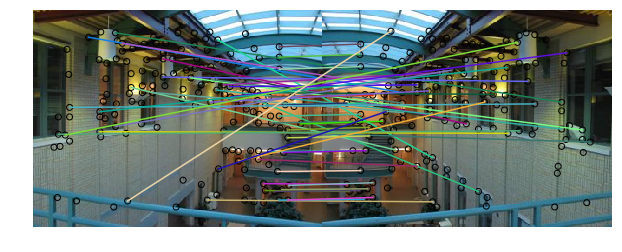

In [2]:
imL = image.imread("images/CMU_left.jpg")
imR = image.imread("images/CMU_right.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)


# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)

## Keypoints provide interest points, in this case --> corners
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.0005, min_distance=5)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.0005, min_distance=5)

extractor = BRIEF()

## Extract out the pixel values based on coordinates ?
extractor.extract(imLgray, keypointsL)

## Retain only those point coordinates which are used for descriptor array
keypointsL = keypointsL[extractor.mask]

## Outcome of the intensity comparison for i-th keypoint on j-th decision pixel-pair
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

## For each descriptor in the first set, this matcher finds the closest descriptor in the second set
## (and vice-versa in the case of enabled cross-checking)
matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)
print 'the number of matches is {:2d}'.format(matchesLR.shape[0])


fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

## Problem 1
### Rederive your formula in Problem 3a from Part I of the assignment for the following modification. Assume there are $N=53$ matches $(p,p')$ as in figure 1 above. $N_i=21$ of these matches are inliers for a homography, while the rest of the matches are $N_o=32$ outliers. To estimate a homography you need a sample with $K=4$ matches. What is the least number of times one should randomly sample a subset of $K$ matches to get probability  $p≥0.95$  that at least one of these samples has all of its $K$ matches from inliers? Derive a general formula and compute a numerical answer for the specified numbers.

Solution: 

Let S be the least number of times one should sample 4 matches from N (i.e. 53 matches) to get probability $p\geq 0.95$. 

Probability of a match being an outlier $= \frac{32}{53}$ 

Probability of choosing 4 matches of inliners in a row $ (1 - \frac{32}{53})^4$

Probability that 4 matches in the sample were outliers = $1 - (1 - \frac{32}{53})^4$

Since minimum desired probability that at least one of the sampled 4 matches are both inliners = 0.95,

$1 - (1 - (1 - \frac{32}{53})^4)^S  = 0.95$

$S = \frac {log(1-0.95)}{log(1 - (1 - \frac{32}{53})^4)} = 120.03 = 121$ (round up)

General formula: $S = \frac{log(1-p)}{log(1-(1-o)^n)}$  ,

where S = least number of samples, p = desired probability that at least one of the sampled 4 matches are inliners, o = probability that a match is an outlier, n = number of matches in a sample (in this case, 4) 

## Problem 2: (RANSAC for Homographies)
### Write code below using RANSAC to estimate Homography from matched pairs of points above. This cell should display new figure 2 similar to figure 1 above, but it should show only inlier pairs for the detected homography. HINT: you can use $ProjectiveTransform$  from library $skimage$ declared at the top of the notebok.

('Number of inliers:', 20)


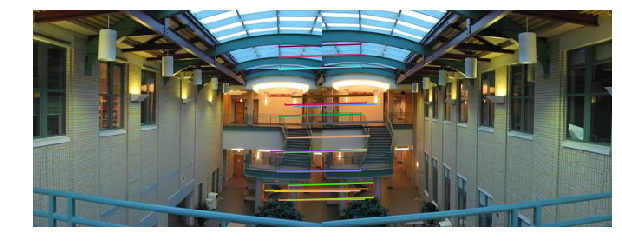

In [3]:
srcGray = np.copy(imLgray)
dstGray =np.copy(imRgray)

## Find the coordinates of the matched points
Lcoord = keypointsL[matchesLR[:, 0]]
Rcoord =  keypointsR[matchesLR[:, 1]]

## Perform estimation of Homography using RANSAC
## Residual_threshold is set to 6 which is 1 more than the minimum distance in the corner_peaks above
model_robust, inliers = ransac((Lcoord, Rcoord), ProjectiveTransform, min_samples=4,
                               residual_threshold=6, max_trials=121)
inlier_idxs = np.nonzero(inliers)[0]
outliers = inliers == False

outlier_idxs = np.nonzero(outliers)[0]
print("Number of inliers:", inliers.sum())

fig = plt.figure(2,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()

## Plot only inliers
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR[inliers], only_matches=True)

axA.axis('off')
plt.show()

## Problem 3 (reprojecting onto common PP)
### Use common PP corresponding to the plane of the left image. Your pamorama mosaic should be build inside a "reference frame" (think about it as an empty canvas of certain size) inside this common PP. The reference frame should be big enough to contain the left image and the part of the view covered by the right image after reprojecting onto common PP. Create a new figure 3 including the following three images (spread them vertically). First, show your reference frame only with the left image inside. Second, show the reference frame containing only a reprojected right image (warp it using a homography computed in Problem 1). Third, for comparison, show the reference frame containing only the right image reprojected using a (bad) homography estimated from all matches (including outliers, as in figure 1).
#### HINT1: use function $warp$ from library $skimage$ declared at the top of the notebook. 
#### HINT2: function $warp$ needs "inverse map" as a (second) argument as it uses "inverse warping" to compute output intensities

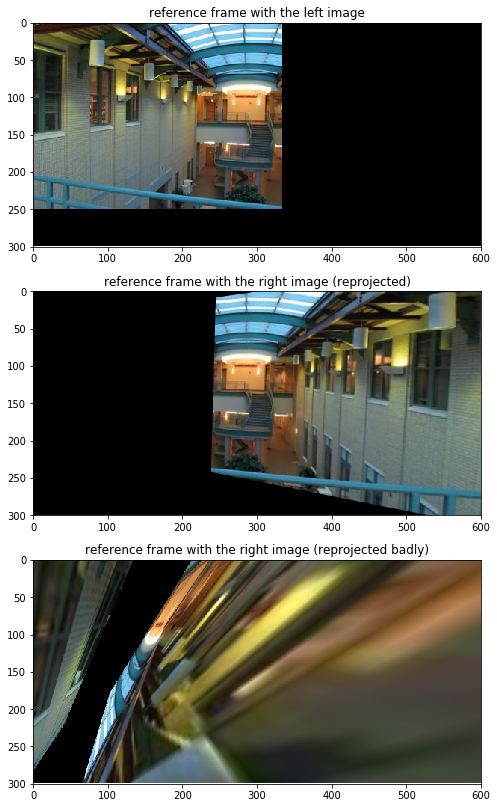

In [4]:
fig = plt.figure(3,figsize = (12, 14))
plt.subplot(311)
plt.title("reference frame with the left image")

## Apply padding so that all images have the same size
pad1D = 300 - imL.shape[0]
pad2D = 600 - imL.shape[1]
npad = ((0, pad1D), (0, pad2D), (0, 0))
leftImg = np.pad(array=imL, pad_width=npad, mode='constant', constant_values=0)
plt.axis([0,600,300,0])

plt.imshow(leftImg)


###############
plt.subplot(312)
rightImg = imR
projRT = ProjectiveTransform()

## Swap (y,x) to (x,y) while using only inliers pairs
swappedL = keypointsL[matchesLR[inliers,0]]
temp = np.copy(swappedL[:, 0])
swappedL[:, 0] = swappedL[:, 1]
swappedL[:, 1] = temp

swappedR = keypointsR[matchesLR[inliers,1]]
temp = np.copy(swappedR[:, 0])
swappedR[:, 0] = swappedR[:, 1]
swappedR[:, 1] = temp

## Estimate homography
projRT.estimate(swappedR,swappedL) 
warpImg = warp(rightImg, inverse_map= projRT.inverse,output_shape =(300,600))

plt.title("reference frame with the right image (reprojected)")
plt.axis([0,600,300,0])
plt.imshow(warpImg)


##############
plt.subplot(313)
rightImg = imR
projBT = ProjectiveTransform()

# Swap (y,x) to (x,y) while using all matches
swappedL2 = keypointsL[matchesLR[:, 0]]
temp = np.copy(swappedL2[:, 0])
swappedL2[:, 0] = swappedL2[:, 1]
swappedL2[:, 1] = temp

swappedR2 = keypointsR[matchesLR[:, 1]]
temp = np.copy(swappedR2[:, 0])
swappedR2[:, 0] = swappedR2[:, 1]
swappedR2[:, 1] = temp

## Estimate homography
projBT.estimate(swappedL2,swappedR2) 
badWarpImg = warp(rightImg, inverse_map=projBT.inverse, output_shape = (300, 600))

plt.title("reference frame with the right image (reprojected badly)")
plt.axis([0,600,300,0])
plt.imshow(badWarpImg)


plt.show()


## Problem 4 (blending)

### (part a) Write code for a function below computing distance transform for the boundary of a given image. It returns a numpy array of the same size as the image with distances from each pixel to the closest point on the boundary of the image (float values). 
   

In [5]:
def boundaryDT(img):
    ## width = row
    width = img.shape[1]/75.0
    ## height = column
    height = img.shape[0]*width/img.shape[1]
    coordW = width/img.shape[1]
    coordH = height/img.shape[0]
    coordR = img.shape[1]
    coordC = img.shape[0]
    boundDT = np.zeros((img.shape[0],img.shape[1]))
    for h in range(img.shape[0]):
        for w in range(img.shape[1]):
            least = min (w * coordW, h * coordH, (coordC-h) * coordH, (coordR-w)*coordW)
            boundDT[h][w] = least
    return boundDT

boundaryDT (leftImg)                       


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01333333, 0.01333333, ..., 0.01333333, 0.01333333,
        0.01333333],
       [0.        , 0.01333333, 0.02666667, ..., 0.02666667, 0.02666667,
        0.01333333],
       ...,
       [0.        , 0.01333333, 0.02666667, ..., 0.04      , 0.02666667,
        0.01333333],
       [0.        , 0.01333333, 0.02666667, ..., 0.02666667, 0.02666667,
        0.01333333],
       [0.        , 0.01333333, 0.01333333, ..., 0.01333333, 0.01333333,
        0.01333333]])

### (part b) Use function from part (a) to compute a distance transform for both images. Create a new figure 4 showing the follwoing two images. First, show reference frame containing only the left image's boundaryDT instead of the left image. Second, show reference frame containing only the right image's boundaryDT reprojected instead of the right image. 

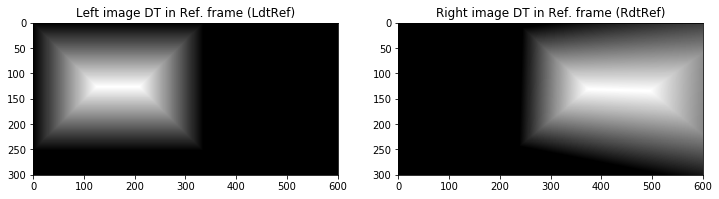

In [6]:
fig = plt.figure(4,figsize = (12, 3))
plt.subplot(121)
plt.title("Left image DT in Ref. frame (LdtRef)")
boundLImg = boundaryDT (imL)

## Apply padding so that all images have the same size
pad1D = 300 - imL.shape[0]
pad2D = 600 - imL.shape[1]
npad = ((0, pad1D), (0, pad2D))
boundLImg = np.pad(array=boundLImg, pad_width=npad, mode='constant', constant_values=0)

plt.axis([0,600,300,0])
plt.imshow(boundLImg)

##################
plt.subplot(122)
plt.title("Right image DT in Ref. frame (RdtRef)")

## Find distance transform for unwarped right image
boundRImg = boundaryDT (imR)
## Warp the distance transform results with the estimated homography
boundWarpRImg = warp(boundRImg, inverse_map= projRT.inverse,output_shape =(300,600))


plt.axis([0,600,300,0])
plt.imshow(boundWarpRImg)

### (part c) Use boundary distance transforms to blend left and right images (reprojected) into the reference frame. Create a new figure 5 showing the following three images. First and second should be $alpha$'s for blending the left and right images. These alphas should be based on distance transforms as discussed in class. Third, should be your panorama: left and (reprojected) right images blended inside the reference frame. Your panorama should also show (reprojected) features - homography inliers - from both left and right images. Use different colors/shapes to distinct features from the left and the right images.

C:\Users\Qing Ru\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


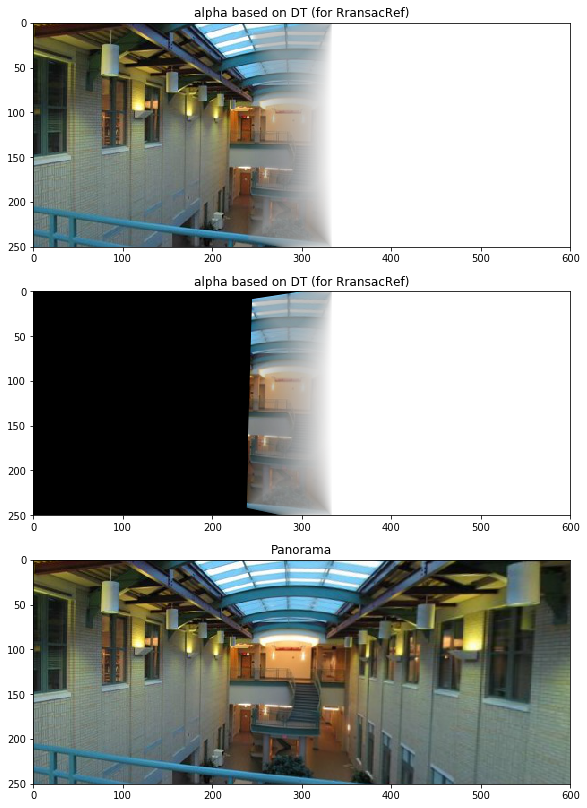

In [7]:
dtrans1 = boundLImg
dtrans2 = boundWarpRImg
alpha = dtrans1/(dtrans1+dtrans2)

fig = plt.figure(5,figsize = (12, 14))

###########
plt.subplot(311)

## Add a 4th transparency channel
newLImg1 = np.dstack((leftImg, np.zeros((alpha.shape[0], alpha.shape[1]))))

## Normalise the RGB left image
def normalise(x):
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
newLImg1 = normalise(newLImg1)

## To display alpha's for blending left image
newLImg1[:, :, 3] = 1
newLImg1[:, :, 0] *= alpha
newLImg1[:, :, 1] *= alpha
newLImg1[:, :, 2] *= alpha
newLImg1[:, :, 3] *= alpha
plt.axis([0,600,250,0])
plt.imshow(newLImg1)
plt.title("alpha based on DT (for RransacRef)")


###########
plt.subplot(312)

## Add a 4th transparency channel
newRImg = np.dstack((warpImg, np.zeros((alpha.shape[0], alpha.shape[1]))))

## To display alpha's for blending right image
newRImg[:, :, 3] = 1
newRImg[:, :, 0] *= alpha
newRImg[:, :, 1] *= alpha
newRImg[:, :, 2] *= alpha
newRImg[:, :, 3] *= alpha
plt.axis([0,600,250,0])
plt.imshow(newRImg)
plt.title("alpha based on DT (for RransacRef)")


###########
plt.subplot(313)

## Add a 4th transparency channel
newRImg2 = np.dstack((warpImg, np.zeros((alpha.shape[0], alpha.shape[1]))))

## Apply feathering
newRImg2[:, :, 3] = 1
newRImg2[:, :, 0] *= (1-alpha)
newRImg2[:, :, 1] *= (1-alpha)
newRImg2[:, :, 2] *= (1-alpha)
newRImg2[:, :, 3] *= (1-alpha)                
panoramaImg =newLImg1+newRImg2

plt.axis([0,600,250,0])
plt.imshow(panoramaImg)
plt.title("Panorama")


plt.show()